<a href="https://colab.research.google.com/github/cagutierrezgu/My_Portfolio/blob/main/Podcast%20topic%20classification/Data%20preparation%20and%20exploration/Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Features extraction
----
Hasta el momento, los textos que se tienen luego de hacer el preprocesamiento se encuentran separados o tockenizados por palabras, lo cual es una ventaja para múltiples aplicaciones. Una de las herramientas que pueden usarse al tener el texto de esta manera es una nube de palabras con **`Wordcloud()`**, de esta manera un primer análisis consiste en determinar el tema de cada podcast a partir de la frecuencia de palabras de este: 

In [ ]:
def word_cloud(text):
    '''Genera nube de palabras dado un texto'''
    txt = ''
    for i in text:
        txt += ' '.join(i)
    stopwords = ['know', 'people', 'yeah', 'kind', 'well', 'really', 'right',
                 'think', 'thing', 'going', 'time', 'like', 'would']    # Palabras muy frecuentes que no aportan al estudio
    wordcloud = WordCloud(background_color = "white", stopwords = stopwords, max_words = 70).generate(txt)
    plt.figure(figsize=[10,10])
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show();

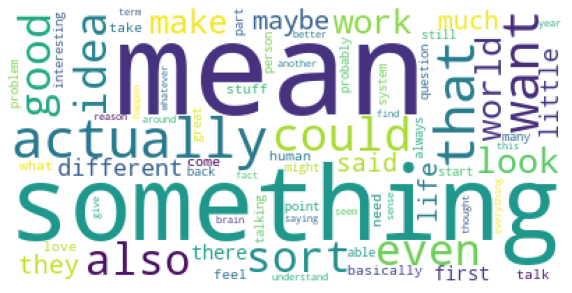

In [ ]:
word_cloud(tock_science)

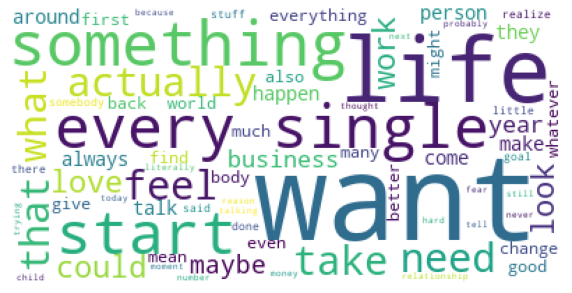

In [ ]:
word_cloud(tock_hf)

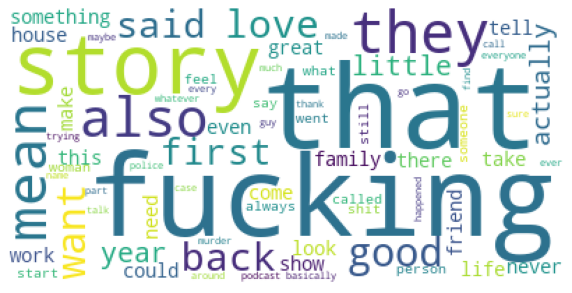

In [ ]:
word_cloud(tock_crime)

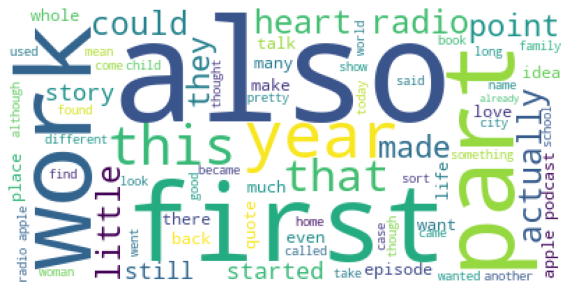

In [ ]:
word_cloud(tock_history)

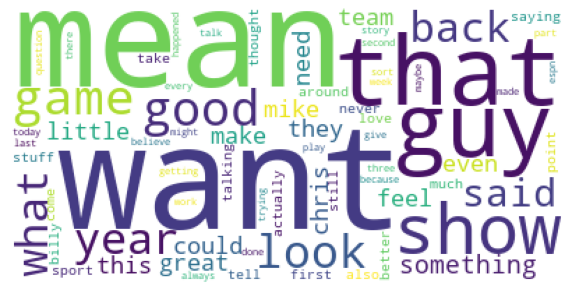

In [ ]:
word_cloud(tock_sports)

Lo anterior permite ver que las diferencias de palabras más frecuentes entre podcasts no es evidente a simple vista, dado que en cada uno de estos las palabras más repetidas son verbos y adjetivos comunes en cualquier conversación, mas no característicos de un tema en específico.

Es por esto que debe optarse por otro tipo de herramienta que permita ver las diferencias entre los textos disponibles. Por ejemplo, un análisis de sentimientos como se muestra a continuación (**es indispensable cargar el léxico *Emolex***):

In [ ]:
import zipfile
with zipfile.ZipFile("emolex.zip","r") as zip_ref:
    zip_ref.extractall("emolex")

In [ ]:
vocab = {}                  # Diccionario con el vocabulario de distintas emociones
base_path = "emolex/emolex"
for lexicon in listdir(base_path):
    with open(
            path.join(base_path, lexicon)
            ) as f:
        vocab[
                lexicon.split(".")[0]
                ] = f.read().split("\n")

In [ ]:
def emotion_count(text, vocab):
    '''Contabiliza el número de palabras de cada emoción en un texto'''
    counts = {i: 0 for i in list(vocab.keys())}
    for word in text:
        for emo in vocab:
            if word in vocab[emo]:
                counts[emo] += 1
    return counts

In [ ]:
# Uniendo los textos de todos los episodios del mismo podcast

full_science = [item for sublist in tock_science for item in sublist]
full_sports = [item for sublist in tock_sports for item in sublist]
full_hf = [item for sublist in tock_hf for item in sublist]
full_history = [item for sublist in tock_history for item in sublist]
full_crime = [item for sublist in tock_crime for item in sublist]

In [ ]:
emotion_science = emotion_count(full_science, vocab)
emotion_sports = emotion_count(full_sports, vocab)
emotion_hf = emotion_count(full_hf, vocab)
emotion_history = emotion_count(full_history, vocab)
emotion_crime = emotion_count(full_crime, vocab)

Una vez se tiene el vocabulario que caracteriza a múltiples emociones es posible visualizar las emociones predominantes en cada podcast: 

In [ ]:
def visualize_emotions(science, sports, hf,
                       history, crime):
    '''
    Genera diagramas circulares de cada
    emoción en cada podcast
    '''
    plt.figure(figsize=(15,20))
    plt.subplot(321)
    plt.pie(science.values(),labels=science.keys())
    plt.title('Distribución para "Ciencia"')
    plt.subplot(322)
    plt.pie(sports.values(),labels=sports.keys())
    plt.title('Distribución para "Deportes"')
    plt.subplot(323)
    plt.pie(hf.values(),labels=hf.keys())
    plt.title('Distribución para "Health & Fitness"')
    plt.subplot(324)
    plt.pie(history.values(),labels=history.keys())
    plt.title('Distribución para "Historia"')
    plt.subplot(325)
    plt.pie(crime.values(),labels=crime.keys())
    plt.title('Distribución para "Crimen"')

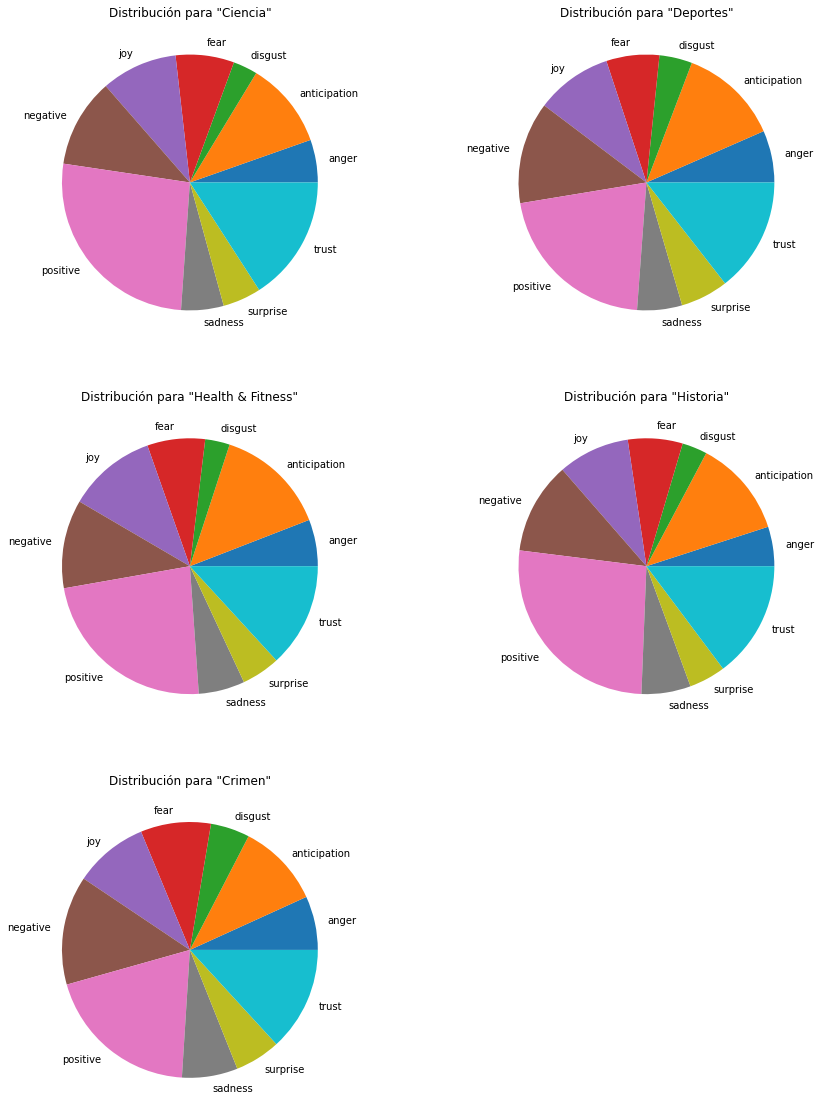

In [ ]:
visualize_emotions(emotion_science, emotion_sports, emotion_hf, emotion_history, emotion_crime)

Nuevamente, tal como ocurrió con la nube de palabras tampoco se aprecian diferencias notorias entre cada temática de podcasts, lo cual puede deberse a la amplia gama de palabras y capítulos que contiene cada conjunto de datos.

Dado lo anterior, se vuelve necesario estudiar el conjunto de datos con modelos más elaborados. En la sección de modelamiento se aplicarán algunos de los modelos más comunes para aprendizaje no supervisado aplicados a lenguaje natural. Es por esto que se utilizarán representaciones de los textos dispuestos en *Bag of words (BoW)*, *TF-IDF* y *Word2Vec*.

En primer lugar, es necesario trabajar con un solo objeto que contenga todos los textos que ya fueron preprocesados:

In [ ]:
full_text = [tock_science, tock_sports, tock_hf, tock_history, tock_crime]
text = [item for sublist in full_text for item in sublist]
#text

A continuación se muestra una de las representaciones a usar de la lista con todos los textos definida anteriormente, correspondiente a **`gensim.models.Word2Vec`**:

In [ ]:
w2v_model = w2v(text, vector_size=300,
                window=5, min_count=1,
                sample=1e-3, epochs=200)

In [ ]:
def w2v_rep(corpus):
    w2v_r = []
    for sentence in corpus:
        try:
            w2v_r.append(w2v_model.wv[sentence].mean(axis=0))
        except:
            w2v_r.append(np.zeros(shape=(feature_size,)))
    return np.array(w2v_r)

X_w2v = w2v_rep(text)
X_w2v.shape

(300, 300)

Lo anterior deja ver que las palabras que contiene la lista *text* están representadas como vectores de un espacio de 300 dimensiones y que se tienen 300 capítulos de podcasts. Antes de continuar con el resto de representaciones a usar, es de bastante utilidad visualizar dichas representaciones en un espacio no de 300 dimensiones, sino de 2, para lo cual se hace uso de **`sklearn.manifold.TSNE`**:

In [ ]:
tsne = TSNE(
    n_components=2,
    random_state=0,
    n_iter=1000,
    perplexity=2,
    verbose=1
    )
T = tsne.fit_transform(X_w2v)

C:\Users\hurom\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\hurom\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 300 samples in 0.001s...
[t-SNE] Computed neighbors for 300 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 0.252028
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.585190
[t-SNE] KL divergence after 1000 iterations: 0.709933


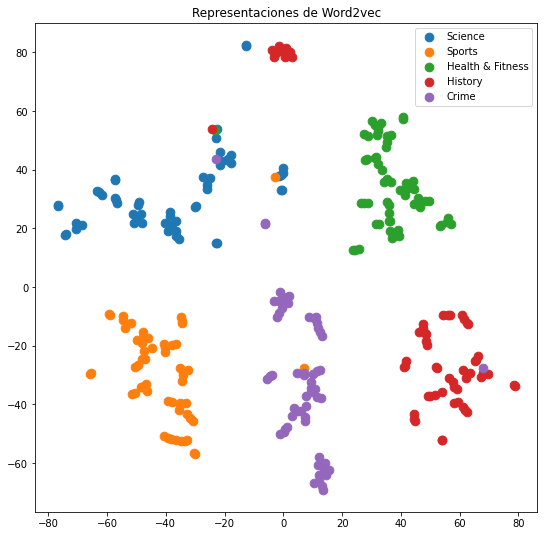

In [ ]:
plt.figure(figsize=(9, 9))
# Visualizamos todas las representaciones
plt.scatter(T[:60, 0], T[:60, 1], s=75, label = 'Science')
plt.scatter(T[60:120, 0], T[60:120, 1], s=75, label = 'Sports')
plt.scatter(T[120:180, 0], T[120:180, 1], s=75, label = 'Health & Fitness')
plt.scatter(T[180:240, 0], T[180:240, 1], s=75, label = 'History')
plt.scatter(T[240:300, 0], T[240:300, 1], s=75, label = 'Crime')
plt.title('Representaciones de Word2vec')
plt.legend();

Donde se hizo distinción por colores de cada uno de los podcasts a estudiar. A primera vista se observan algunos clusters que parecen distinguirse por la temática de cada podcast, y esto es precisamente lo que se estudiará con algunos modelos en la siguiente sección.

Ahora se definirá una representación *TF-IDF* con **`sklearn.feature_extraction.text.TfidfVectorizer`** del texto sin tokenizar:

In [ ]:
text_not_tok = [' '.join(words) for words in text]
tfidf = TfidfVectorizer(
        stop_words="english",
        max_features=1000,
        max_df=0.5,
        sublinear_tf=True
        )
tfidf.fit(text_not_tok)
X_tfidf = tfidf.transform(text_not_tok).toarray()

Por último, será necesario hacer un *bag of words* con **`sklearn.feature_extraction.text.CountVectorizer`** como sigue:

In [ ]:
bow = CountVectorizer(
        max_features=1000,
        max_df=0.5
        )
bow.fit(text_not_tok)
X_bow = bow.transform(text_not_tok).toarray()